In [1]:
import sys, os
import getpass
user = getpass.getuser()
motionbert_root = '/home/{}/codes/MotionBERT'.format(user)
alphapose_root = '/home/{}/codes/AlphaPose/'.format(user)
motionbert_root, alphapose_root

('/home/hrai/codes/MotionBERT', '/home/hrai/codes/AlphaPose/')

### 영상 하나 추론

In [3]:
os.chdir(motionbert_root)

video = '30_M160A_3'
#model = 'MB_ft_h36m'
#epoch = 'best_epoch'
model = 'FT_MB_ft_h36m_MB_ft_aihub_30'
epoch = 'best_epoch'
out_path = 'output/aihub_30/{}_{}'.format(model, video)

if os.path.exists(out_path): # 이미 추론 결과가 있으면 넘어감
    print("MotionBERT_{} already exists".format(video))
else:
    # args
    config = "configs/pose3d/{}.yaml".format('MB_ft_aihub_30')
    evaluate = "checkpoint/pose3d/{}/{}.bin".format(model, epoch)
    vid_path = alphapose_root + 'examples/aihub_result/res_{}/test.mp4'.format(video)
    json_path = alphapose_root + 'examples/aihub_result/res_{}/alphapose-results.json'.format(video)

    try:
        # inference by MotionBERT
        os.system("python infer_wild.py --config {} --vid_path {} --json_path {} --out_path {} --evaluate {}".format(config, vid_path, json_path, out_path, evaluate))
        # change the name of the output
        os.rename(os.path.join(out_path, "X3D.mp4"), os.path.join(out_path, "MotionBERT_{}.mp4".format(video)))
        os.rename(os.path.join(out_path, "X3D.npy"), os.path.join(out_path, "MotionBERT_{}.npy".format(video)))
    except:
        print("MotionBERT_{} failed".format(id))
    

Loading checkpoint checkpoint/pose3d/FT_MB_ft_h36m_MB_ft_aihub_30/best_epoch.bin


100%|██████████| 144/144 [00:13<00:00, 11.03it/s]


In [2]:
import sys, os

os.chdir('/home/lhs/codes/MotionBERT')

# id = 운동종류, actor, 카메라 번호
action = "30_Squat"
l = os.listdir("/home/lhs/Datasets/HAAI/{}".format(action)) # 30_Squat id 리스트
for id in l: # 각 영상에 대해 
    print(id)
    if "MotionBERT_{}".format(id) in os.listdir("./output"): # 이미 추론 결과가 있으면 넘어감
        print("MotionBERT_{} already exists".format(id))
        continue
    
    # args
    #config = "configs/pose3d/MB_ft_aihub.yaml"
    evaluate = "checkpoint/pose3d/FT_MB_ft_h36m_MB_ft_aihub_243/latest_epoch.bin"
    #checkpoint = "checkpoint/pose3d/MB_ft_h36m/best_epoch.bin"
    vid_path = '/home/lhs/codes/AlphaPose/examples/res_{}/vis/test.mp4'.format(id)
    json_path = '/home/lhs/codes/AlphaPose/examples/res_{}/alphapose-results.json'.format(id)
    out_path = './output/MotionBERT_{}'.format(id)

    try:
        # inference by MotionBERT
        os.system("python infer_wild.py --vid_path {} --json_path {} --out_path {} --evaluate {}".format(vid_path, json_path, out_path, evaluate))
        # change the name of the output
        os.rename(os.path.join(out_path, "X3D.mp4"), os.path.join(out_path, "MotionBERT_{}.mp4".format(id)))
        os.rename(os.path.join(out_path, "X3D.npy"), os.path.join(out_path, "MotionBERT_{}.npy".format(id)))
    except:
        print("MotionBERT_{} failed".format(id))
        
    break

30_M160D_3
Loading checkpoint checkpoint/pose3d/FT_MB_ft_h36m_MB_ft_aihub_243/latest_epoch.bin


100%|██████████| 388/388 [00:56<00:00,  6.87it/s]


In [90]:
os.chdir(motionbert_root)

import os
import numpy as np
import argparse
from tqdm import tqdm
import imageio
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from lib.utils.tools import *
from lib.utils.learning import *
from lib.utils.utils_data import flip_data
from lib.data.dataset_wild import WildDetDataset
from lib.utils.vismo import render_and_save

In [91]:
import easydict

video = '30_M160A_3'
out_path = 'output/MotionBERT_{}'.format(video)
evaluate = "checkpoint/pose3d/MB_ft_h36m/best_epoch.bin"
vid_path = alphapose_root + 'examples/aihub_result/res_{}/test.mp4'.format(video)
json_path = alphapose_root + 'examples/aihub_result/res_{}/alphapose-results.json'.format(video)

opts = easydict.EasyDict({
    "config": "configs/pose3d/MB_ft_h36m.yaml",
    "evaluate": evaluate,
    "json_path": json_path,
    "vid_path": vid_path,
    "out_path": out_path,
    "pixel": True,
    "focus": None,
    "clip_len": 243,
    })
args = get_config(opts.config)

In [92]:
model_backbone = load_backbone(args)
if torch.cuda.is_available():
    model_backbone = nn.DataParallel(model_backbone)
    model_backbone = model_backbone.cuda()

print('Loading checkpoint', opts.evaluate)
checkpoint = torch.load(opts.evaluate, map_location=lambda storage, loc: storage)
model_backbone.load_state_dict(checkpoint['model_pos'], strict=True)
model_pos = model_backbone
model_pos.eval()
testloader_params = {
          'batch_size': 1,
          'shuffle': False,
          'num_workers': 8,
          'pin_memory': True,
          'prefetch_factor': 4,
          'persistent_workers': True,
          'drop_last': False
}

Loading checkpoint checkpoint/pose3d/MB_ft_h36m/best_epoch.bin


In [24]:
opts.vid_path

'/home/hrai/codes/AlphaPose/examples/aihub_result/res_30_M160A_3/test.mp4'

In [25]:
vid = imageio.get_reader(opts.vid_path,  'ffmpeg')
fps_in = vid.get_meta_data()['fps']
vid_size = vid.get_meta_data()['size']
os.makedirs(opts.out_path, exist_ok=True)

In [89]:
vid_size

(1920, 1080)

In [26]:
opts.out_path

'output/MotionBERT_30_M160A_3'

In [27]:
opts.pixel

True

In [28]:
opts.json_path

'/home/hrai/codes/AlphaPose/examples/aihub_result/res_30_M160A_3/alphapose-results.json'

In [29]:
if opts.pixel:
    # Keep relative scale with pixel coornidates
    wild_dataset = WildDetDataset(opts.json_path, clip_len=opts.clip_len, vid_size=vid_size, scale_range=None, focus=opts.focus)
else:
    # Scale to [-1,1]
    wild_dataset = WildDetDataset(opts.json_path, clip_len=opts.clip_len, scale_range=[1,1], focus=opts.focus)
test_loader = DataLoader(wild_dataset, **testloader_params)

In [30]:
results_all = []
with torch.no_grad():
    for batch_input in tqdm(test_loader):
        N, T = batch_input.shape[:2]
        if torch.cuda.is_available():
            batch_input = batch_input.cuda()
        if args.no_conf:
            batch_input = batch_input[:, :, :, :2]
        if args.flip:    
            batch_input_flip = flip_data(batch_input)
            predicted_3d_pos_1 = model_pos(batch_input)
            predicted_3d_pos_flip = model_pos(batch_input_flip)
            predicted_3d_pos_2 = flip_data(predicted_3d_pos_flip) # Flip back
            predicted_3d_pos = (predicted_3d_pos_1 + predicted_3d_pos_2) / 2.0
        else:
            predicted_3d_pos = model_pos(batch_input)
        if args.rootrel:
            predicted_3d_pos[:,:,0,:]=0                    # [N,T,17,3]
        else:
            predicted_3d_pos[:,0,0,2]=0
            pass
        if args.gt_2d:
            predicted_3d_pos[...,:2] = batch_input[...,:2]
        results_all.append(predicted_3d_pos.cpu().numpy())
results_all[0].shape

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


(1, 144, 17, 3)

In [31]:
results_all = np.hstack(results_all)
results_all.shape

(1, 144, 17, 3)

In [32]:
results_all = np.concatenate(results_all)
results_all.shape

(144, 17, 3)

In [34]:
from lib.utils.vismo import *
from lib.utils.tools import ensure_dir

In [35]:
motion_input = results_all
save_path = '%s/X3D.mp4' % (opts.out_path)
keep_imgs=False
fps=fps_in
color="#F96706#FB8D43#FDB381"
with_conf=False
draw_face=False

### render_and_save

In [36]:
save_path

'output/MotionBERT_30_M160A_3/X3D.mp4'

In [37]:
os.path.dirname(save_path)

'output/MotionBERT_30_M160A_3'

In [38]:
ensure_dir(os.path.dirname(save_path))

In [39]:
motion = copy.deepcopy(motion_input)
motion.shape

(144, 17, 3)

In [40]:
if motion.shape[-1]==2 or motion.shape[-1]==3:
    motion = np.transpose(motion, (1,2,0))   #(T,17,D) -> (17,D,T) 
motion.shape

(17, 3, 144)

In [41]:
with_conf, motion.shape[1], motion.shape[0]

(False, 3, 17)

#### pixel2world_vis_motion

In [42]:
motion = motion
dim=3
is_tensor=False

In [43]:
N = motion.shape[-1]
if dim==2: # 2D
    offset = np.ones([2,N]).astype(np.float32)
else: # 3D
    offset = np.ones([3,N]).astype(np.float32)
    offset[2,:] = 0
offset.shape

(3, 144)

In [44]:
is_tensor

False

In [45]:
if is_tensor:
    offset = torch.tensor(offset)

In [46]:
motion

array([[[ 1.46327249e-04,  1.39424563e-04,  1.39037584e-04, ...,
         -1.19954173e-04, -1.19887583e-04, -1.19201373e-04],
        [ 5.70004340e-06,  1.43352663e-05,  3.26040899e-05, ...,
          1.89769780e-05,  3.25072324e-05,  4.17534029e-05],
        [ 0.00000000e+00,  5.52093145e-04,  5.55301318e-04, ...,
         -2.41508242e-05, -2.96160579e-07,  9.78377648e-06]],

       [[ 4.86699790e-02,  4.85939756e-02,  4.85517047e-02, ...,
          4.56868708e-02,  4.56704311e-02,  4.56577688e-02],
        [ 7.40985945e-03,  7.38331303e-03,  7.41557777e-03, ...,
          1.49993282e-02,  1.50940306e-02,  1.51620992e-02],
        [-6.22830987e-02, -6.23078458e-02, -6.22697696e-02, ...,
         -6.20501339e-02, -6.20230138e-02, -6.19743057e-02]],

       [[ 3.77475657e-02,  3.76941040e-02,  3.76918614e-02, ...,
          2.39460886e-01,  2.39675909e-01,  2.39857331e-01],
        [ 2.10896447e-01,  2.10841998e-01,  2.10833952e-01, ...,
         -1.77267790e-02, -2.05229837e-02, -2.275

In [47]:
motion_world = (motion + offset) * 512 / 2

In [48]:
motion_world

array([[[ 2.5603745e+02,  2.5603571e+02,  2.5603558e+02, ...,
          2.5596930e+02,  2.5596931e+02,  2.5596948e+02],
        [ 2.5600146e+02,  2.5600366e+02,  2.5600836e+02, ...,
          2.5600485e+02,  2.5600833e+02,  2.5601068e+02],
        [ 0.0000000e+00,  1.4133584e-01,  1.4215714e-01, ...,
         -6.1826110e-03, -7.5817108e-05,  2.5046468e-03]],

       [[ 2.6845950e+02,  2.6844006e+02,  2.6842923e+02, ...,
          2.6769583e+02,  2.6769162e+02,  2.6768839e+02],
        [ 2.5789691e+02,  2.5789014e+02,  2.5789838e+02, ...,
          2.5983981e+02,  2.5986407e+02,  2.5988150e+02],
        [-1.5944473e+01, -1.5950809e+01, -1.5941061e+01, ...,
         -1.5884834e+01, -1.5877892e+01, -1.5865422e+01]],

       [[ 2.6566339e+02,  2.6564969e+02,  2.6564911e+02, ...,
          3.1730200e+02,  3.1735703e+02,  3.1740347e+02],
        [ 3.0998950e+02,  3.0997556e+02,  3.0997348e+02, ...,
          2.5146194e+02,  2.5074611e+02,  2.5017580e+02],
        [ 1.5832747e+01,  1.5846483e

#### motion2video_3d

In [49]:
save_path, keep_imgs, fps

('output/MotionBERT_30_M160A_3/X3D.mp4', False, 60.0)

In [50]:
motion=motion_world
save_path=save_path
fps=fps
keep_imgs = keep_imgs

In [79]:
#videowriter = imageio.get_writer(save_path, fps=fps)
vlen = motion.shape[-1] # N
save_name = save_path.split('.')[0] # 'output/MotionBERT_30_M160A_3/X3D'
frames = []
joint_pairs = [[0, 1], [1, 2], [2, 3], [0, 4], [4, 5], [5, 6], [0, 7], [7, 8], [8, 9], [8, 11], [8, 14], [9, 10], [11, 12], [12, 13], [14, 15], [15, 16]]
joint_pairs_left = [[8, 11], [11, 12], [12, 13], [0, 4], [4, 5], [5, 6]]
joint_pairs_right = [[8, 14], [14, 15], [15, 16], [0, 1], [1, 2], [2, 3]]

color_mid = "#00457E"
color_left = "#02315E"
color_right = "#2F70AF"

 21%|██        | 30/144 [00:07<00:27,  4.08it/s]


KeyboardInterrupt: 

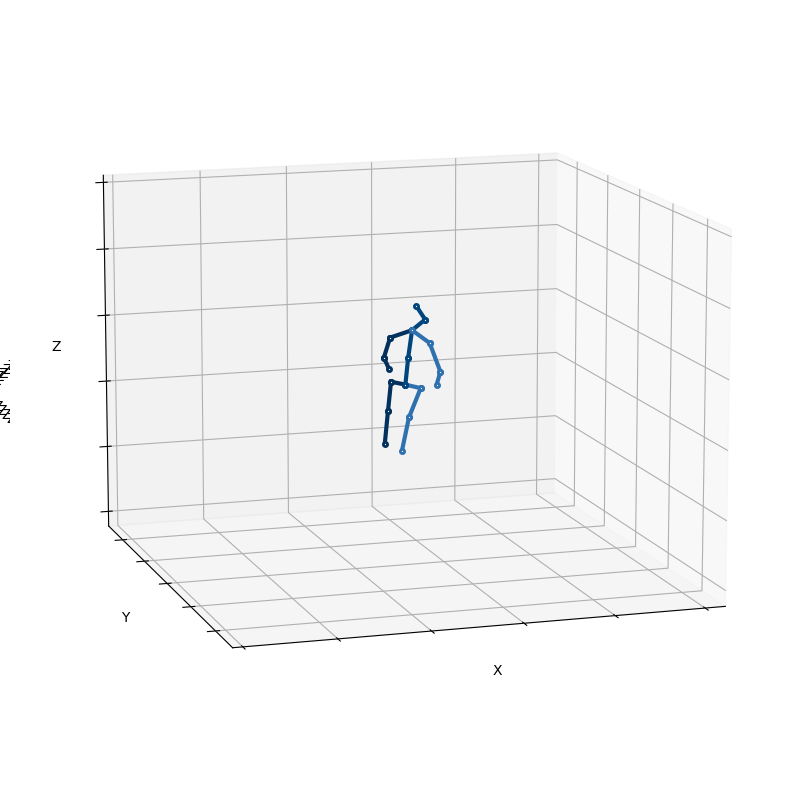

In [88]:
for f in tqdm(range(vlen)):
    j3d = motion[:,:,f] # (17, 3)
    fig = plt.figure(0, figsize=(10, 10))
    fig.canvas.draw()
    ax = plt.axes(projection="3d")
    ax.set_xlim(-512, 0)
    ax.set_ylim(-256, 256)
    ax.set_zlim(-512, 0)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=12., azim=f*360.0/vlen)
    plt.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)
    for i in range(len(joint_pairs)):
        limb = joint_pairs[i]
        xs, ys, zs = [np.array([j3d[limb[0], j], j3d[limb[1], j]]) for j in range(3)]
        if joint_pairs[i] in joint_pairs_left:
            ax.plot(-xs, -zs, -ys, color=color_left, lw=3, marker='o', markerfacecolor='w', markersize=3, markeredgewidth=2) # axis transformation for visualization
        elif joint_pairs[i] in joint_pairs_right:
            ax.plot(-xs, -zs, -ys, color=color_right, lw=3, marker='o', markerfacecolor='w', markersize=3, markeredgewidth=2) # axis transformation for visualization
        else:
            ax.plot(-xs, -zs, -ys, color=color_mid, lw=3, marker='o', markerfacecolor='w', markersize=3, markeredgewidth=2) # axis transformation for visualization
    frame_vis = get_img_from_fig(fig)
    #videowriter.append_data(frame_vis)
#videowriter.close()   

In [ ]:
opts.pixel

In [108]:
if opts.pixel:
    # Convert to pixel coordinates
    results_all = results_all * (min(vid_size) / 2.0)
    results_all[:,:,:2] = results_all[:,:,:2] + np.array(vid_size) / 2.0
np.save('%s/X3D.npy' % (opts.out_path), results_all)

In [16]:
os.chdir(motionbert_root)
import numpy as np
from lib.utils.vismo import render_and_save

In [17]:
video = '30_M160A_3'
result_folder = '/home/hrai/codes/MotionBERT/output/MotionBERT_{}'.format(video)
results_all = np.load(result_folder + '/MotionBERT_{}.npy'.format(video))

In [18]:
motion_input = results_all
save_path = '{}/MotionBERT_{}.mp4'.format(result_folder, video)
fps=60

100%|██████████| 144/144 [05:09<00:00,  2.15s/it]


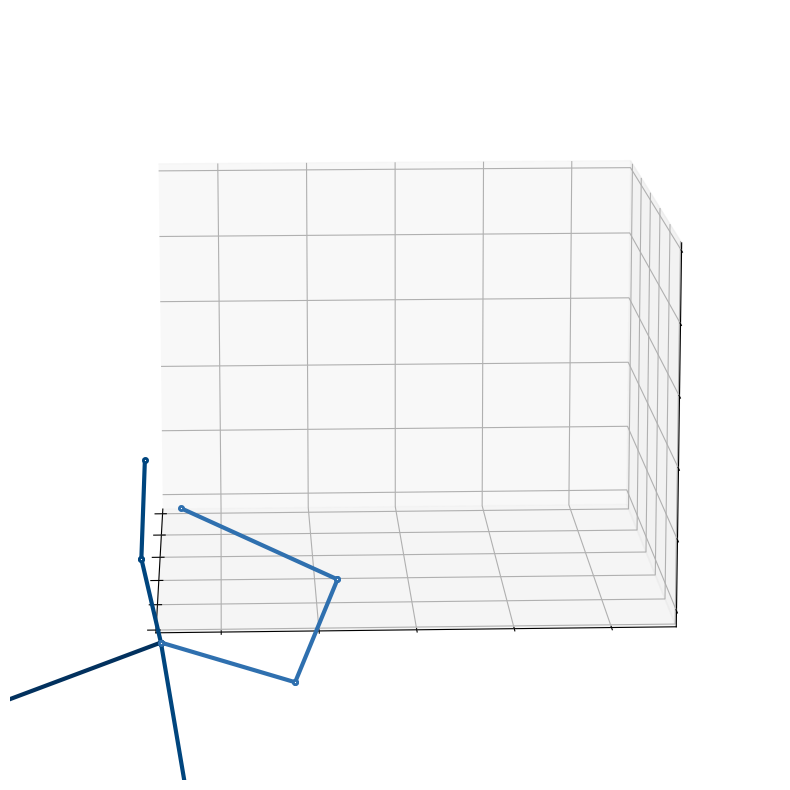

In [19]:
render_and_save(motion_input, save_path, fps)